## Demand Forecasting with LightGBM, SES, DES, TES, ARIMA and SARIMA


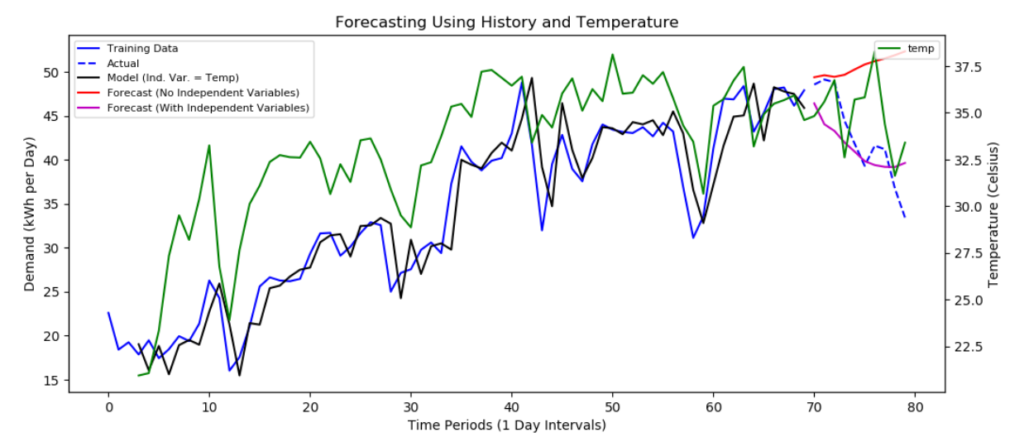

## Content
1. [Introduction](#section-intro)
2. [Load Dataset and EDA](#section-ts)
3. [Feature Engineering](#section-pro)
    * [Random Noise](#section-one)
    * [Lag/Shifted Features ](#section-two)
    * [Rolling Mean Features ](#section-three)    
    * [Exponentially Weighted Mean Features ](#section-four)
4. [MODEL](#section-ten)
    * [One-Hot Encoding](#section-eleven)
    * [Converting sales to log(1+sales)](#section-eleven)
    * [LightGBM Model](#section-twelve) 
    * [Custom Cost Function](#section-thirteen)
    * [Final Model](#section-fourteen)
    * [1.Mağazanın 1. Ürünü için Yapılan Tahminler](#section-fifteen)
    * [1.Mağazanın 17. Ürünü için Tahmin Edilen Değerler](#section-fifteen)
5. [TIME SERIES PART](#section-ten)
    * [Load Dataset and EDA](#section-eleven)
    * [Feature Engineering](#section-eleven)
    * [LightGBM Model](#section-eleven)
    * [Feature Importance](#section-eleven)
    * [Time Series Analysis](#section-eleven)
    * [Single Exponential Smoothing ](#section-eleven)
    * [Double Exponential Smoothing](#section-eleven)
    * [Triple Exponential Smoothing ](#section-eleven)
    * [ARIMA](#section-eleven)
    * [SARIMA](#section-eleven)
    

## 1. Introduction

#### Veri Setine Genel Bakış
* Bir mağaza zincirinin 5 yıllık verilerinde, 10 farklı mağaza ve 50 farklı ürünün bilgileri yer almaktadır.
* Veri seti 01-01-2013 ile 31-12-2017 arasındaki dönemi kapsamaktadır.

#### İş Problemi
* Bir mağaza zincirinin 10 farklı mağazası ve 50 farklı ürünü için 3 aylık bir talep tahmini modeli oluşturulmak istenmektedir.
* Daha sonra ise veri seti haftalığa indirgenip 2017 yılı için bir talep tahmin modeli oluşturulmak istenmektedir.

#### Değişkenler
* date – Satış verilerinin tarihi Tatil efekti veya mağaza kapanışı yoktur.
* store – Mağaza ID’si Her bir mağaza için eşsiz numara.
* item – Ürün ID’si Her bir ürün için eşsiz numara.
* sales – Satılan ürün sayıları, Belirli bir tarihte belirli bir mağazadan satılan ürünlerin sayısı

In [1]:
# Gerkli Kütüphaneler ve Ayarlar

import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools

import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/demand-forecasting-kernels-only/sample_submission.csv
/kaggle/input/demand-forecasting-kernels-only/train.csv
/kaggle/input/demand-forecasting-kernels-only/test.csv


## 2. Load Dataset and EDA

In [2]:
train = pd.read_csv('../input/demand-forecasting-kernels-only/train.csv', parse_dates=['date'])
test = pd.read_csv('../input/demand-forecasting-kernels-only/test.csv', parse_dates=['date'])
df = pd.concat([train, test], sort=False) # veri önişleme için test ve train bir araya getirdim
df.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


In [3]:
print("Train setinin boyutu:",train.shape)
print("Test setinin boyutu:",test.shape)

Train setinin boyutu: (913000, 4)
Test setinin boyutu: (45000, 4)


In [4]:
df.shape

(958000, 5)

In [5]:
df.quantile([0, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1]).T # Aykırılık gözükmüyor.

,0.00,0.05,0.25,0.50,0.75,0.95,0.99,1.00
store,1.0,1.00,3.00,5.5,8.00,10.00,10.00,10.0
item,1.0,3.00,13.00,25.5,38.00,48.00,50.00,50.0
sales,0.0,16.00,30.00,47.0,70.00,107.00,135.00,231.0
id,0.0,2249.95,11249.75,22499.5,33749.25,42749.05,44549.01,44999.0


In [6]:
df["date"].min()

Timestamp('2013-01-01 00:00:00')

In [7]:
df["date"].max()

Timestamp('2018-03-31 00:00:00')

In [8]:
# Satış dağılımı nasıl?
df["sales"].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
10%          20.000000
30%          33.000000
50%          47.000000
70%          64.000000
80%          76.000000
90%          93.000000
95%         107.000000
99%         135.000000
max         231.000000
Name: sales, dtype: float64

In [9]:
# Kaç store var?
df["store"].nunique()

10

In [10]:
# Kaç ürün var?
df["item"].nunique() 

50

In [11]:
# Her store'da eşit sayıda mı eşsiz ürün var?
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [12]:
# Mağaza-ürün kırılımında satış istatistikleri
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

## 3. Feature Engineering

In [13]:
# hangi ayda satış yapılmış
df['month'] = df.date.dt.month
# ayın hangi gününde satış yapılmış
df['day_of_month'] = df.date.dt.day
# yılın hangi gününde satış yapılmış
df['day_of_year'] = df.date.dt.dayofyear 
# yılın hangi haftasında satış yapılmış
df['week_of_year'] = df.date.dt.weekofyear
# haftanın hangi gününde satış yapılmış
df['day_of_week'] = df.date.dt.dayofweek
# hangi yılda satış yapılmış
df['year'] = df.date.dt.year
# haftasonu mu değil mi
df["is_wknd"] = df.date.dt.weekday // 4
# ayın başlangıcı mı
df['is_month_start'] = df.date.dt.is_month_start.astype(int)
# ayın bitişi mi
df['is_month_end'] = df.date.dt.is_month_end.astype(int) 

In [14]:
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0


In [15]:
# store-item-month kırılımında satış istatistikleri
df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

### Random Noise

In [16]:
# Bu veri seti gibi küçük veri kümeleri için, overfittingi önlemek amacıyla değerlere rastgele gürültü eklenebilir.
# Ben burada normal olarak 1 standart sapma ve 0 ortalama ile dağılan Gauss rastgele gürültüsünü ekleyeceğim.

def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

### Lag/Shifted Features (Gecikmeler)

In [17]:
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)
df.head(10)

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0
5,2013-01-06,1,1,12.0,NaN,1,6,6,1,6,2013,1,0,0
6,2013-01-07,1,1,10.0,NaN,1,7,7,2,0,2013,0,0,0
7,2013-01-08,1,1,9.0,NaN,1,8,8,2,1,2013,0,0,0
8,2013-01-09,1,1,12.0,NaN,1,9,9,2,2,2013,0,0,0
9,2013-01-10,1,1,9.0,NaN,1,10,10,2,3,2013,0,0,0


In [18]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

### Rolling Mean Features (Hareketli Ortalamalar)

In [19]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [365, 546, 730])


### Exponentially Weighted Mean Features (Üssel Ağırlıklı Ortalama Featureları)

In [20]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


alphas = [0.99, 0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)

In [21]:
df.tail()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730,sales_ewm_alpha_099_lag_91,sales_ewm_alpha_099_lag_98,sales_ewm_alpha_099_lag_105,sales_ewm_alpha_099_lag_112,sales_ewm_alpha_099_lag_180,sales_ewm_alpha_099_lag_270,sales_ewm_alpha_099_lag_365,sales_ewm_alpha_099_lag_546,sales_ewm_alpha_099_lag_728,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,39.241123,52.562713,67.685132,70.248864,67.282662,83.247982,79.766689,56.325028,96.491794,72.425570,88.827567,84.738666,83.948169,41.102494,53.993266,66.871500,67.862074,81.979884,112.096892,66.149794,96.496783,72.783196,41.561777,54.028375,66.387487,67.349358,81.895724,112.421502,66.744209,94.617783,71.979468,42.244368,54.197995,65.849785,66.785772,81.777579,112.682169,67.473304,92.561560,71.115472,43.955442,54.879654,64.996171,65.861563,81.488819,112.703381,68.859556,89.361543,69.838571,46.091666,55.909793,64.428121,65.144155,81.162051,112.055216,70.090358,87.248414,69.116907,51.309755,58.648702,64.033868,64.335072,80.828687,109.036310,71.734958,85.489012,68.933911
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,64.796033,52.915159,64.036676,60.439430,77.923109,83.588666,80.165936,70.510255,81.100145,69.068186,89.901066,84.145825,82.342084,62.781025,51.029933,66.998715,60.078621,89.919799,118.930969,60.061498,80.164968,68.047832,61.928089,51.151419,66.969374,60.367468,89.594786,118.671075,60.337210,80.730889,68.198973,60.924437,51.319799,66.884978,60.678577,89.177758,118.368217,60.747330,81.256156,68.311547,59.191088,51.775931,66.599234,61.172313,88.297764,117.740676,61.771911,81.872309,68.367714,57.927500,52.472938,66.228436,61.543247,87.348615,116.916565,63.027108,82.174524,68.335072,57.154878,54.824351,65.516934,62.167536,85.414343,114.018155,65.867479,82.744506,68.466956
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0,56.590614,62.717556,70.494816,64.615606,73.988943,88.770669,84.378585,67.005845,101.301515,75.434898,88.178983,86.153911,82.327941,59.037810,62.880299,71.949987,65.940786,102.869198,119.989310,72.870615,98.811650,74.930478,59.146404,62.407571,71.748469,65.718373,102.329739,119.933554,72.366861,98.086544,74.659949,59.192444,61.831980,71.488498,65.467858,101.617776,119.836822,71.774733,97.225616,74.331155,59.038218,60.755186,70.919847,65.034463,100.059553,119.548135,70.754382,95.574462,73.673543,58.678250,59.841881,70.268531,64.662974,98.304585,119.074969,70.008132,93.952357,73.000522,58.077439,58.912176,68.758467,64.083768,94.207172,117.009078,69.433740,90.872253,71.733478
44998

## 4. MODEL (3 Aylık Talep Tahmini için)

### One-Hot Encoding

In [22]:
# Değişken türetme işlerim bitti şimdi ML hazırlıklarına başlıyorum.
df = pd.get_dummies(df, columns=['day_of_week', 'month'])

### Converting sales to log(1+sales)

In [23]:
df['sales'] = np.log1p(df["sales"].values)

### LightGBM Model

In [24]:
# 2017'nin başına kadar (2016'nın sonuna kadar) train seti.
train = df.loc[(df["date"] < "2017-01-01"), :]

# 2017'nin ilk 3'ayı validasyon seti.
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

# bağımsız değişkenler
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

In [25]:
# train seti için bağımlı değişkenin seçilmesi
Y_train = train['sales']

# train seti için bağımsız değişkenin seçilmesi
X_train = train[cols]

# validasyon seti için bağımlı değişkenin seçilmesi
Y_val = val['sales']

# validasyon seti için bağımsız değişkenin seçilmesi
X_val = val[cols] 

# kontrol
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 94), (45000,), (45000, 94))

In [26]:
# Custom Cost Function

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False


In [27]:
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000, 
              'early_stopping_rounds': 200,
              'nthread': -1}

In [28]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape, # hatyı gözlemliyoruz
                  verbose_eval=100)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

# validasyon hatasının yüzdesi
smape(np.expm1(y_pred_val), np.expm1(Y_val))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.395648 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.171601	training's SMAPE: 17.502	valid_1's l1: 0.171595	valid_1's SMAPE: 17.5376
[200]	training's l1: 0.14134	training's SMAPE: 14.477	valid_1's l1: 0.145068	valid_1's SMAPE: 14.8813
[300]	training's l1: 0.135754	training's SMAPE: 13.9175	valid_1's l1: 0.140081	valid_1's SMAPE: 14.3809
[400]	training's l1: 0.133649	training's SMAPE: 13.707	valid_1's l1: 0.138313	valid_1's SMAPE: 14.2039
[500]	training's l1: 0.132464	training's SMAPE: 13.5883	valid_1's l1: 0.136913	valid_1's SMAPE: 14.0634
[600]	training's l1: 0.131628	training's SMAPE: 13.5044	valid_1's l1: 0.135941	valid_1's SMAPE: 13.9655
[700]	training's l1: 0.13102	training's SMAPE: 13.4434	valid_1's l1: 0.135169	valid_1's SMAPE: 13.8877
[800]	training's l1: 0.130552	training's SMAPE: 13

13.475711825719356

### Final Model

In [29]:
# test ve train bağımlı/bağımsız değişkenlerinin belirlenmesi

train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

test = df.loc[df.sales.isna()]
X_test = test[cols]

In [30]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.439552 seconds.
You can set `force_col_wise=true` to remove the overhead.


### 1. mağazanın 1.ürünleri için yapılan tahminler

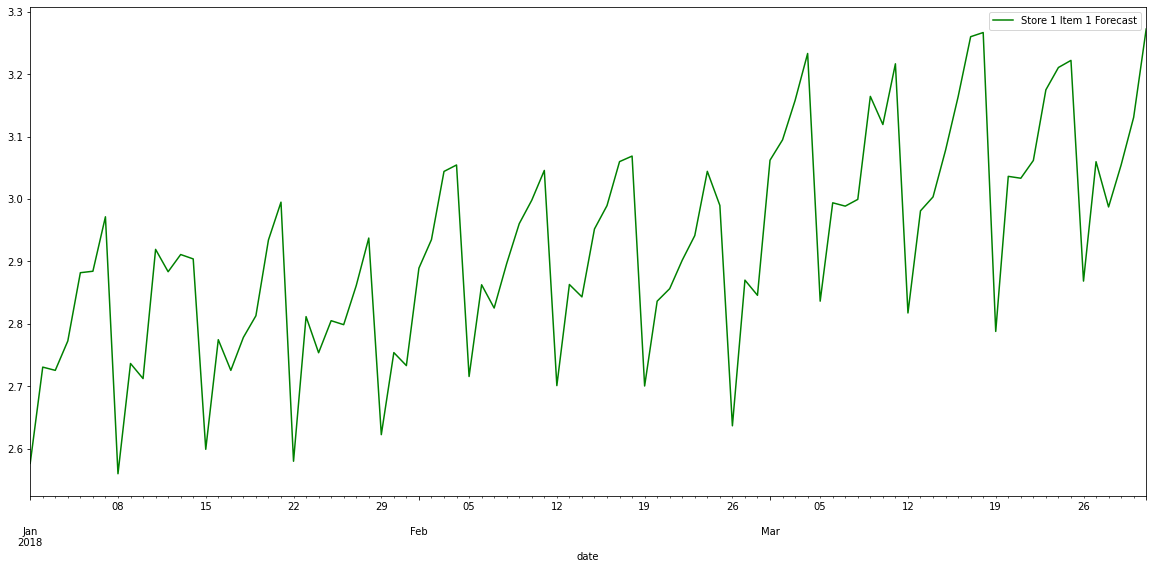

In [31]:
forecast = pd.DataFrame({"date":test["date"],
                        "store":test["store"],
                        "item":test["item"],
                        "sales":test_preds
                        })

forecast[(forecast.store == 1) & (forecast.item == 1)].set_index("date").sales.plot(color = "green",
                                                                                    figsize = (20,9),
                                                                                    legend=True, label = "Store 1 Item 1 Forecast");


### 1.Mağazanın 17. Ürünü İçin Tahmin Edilen Değerler

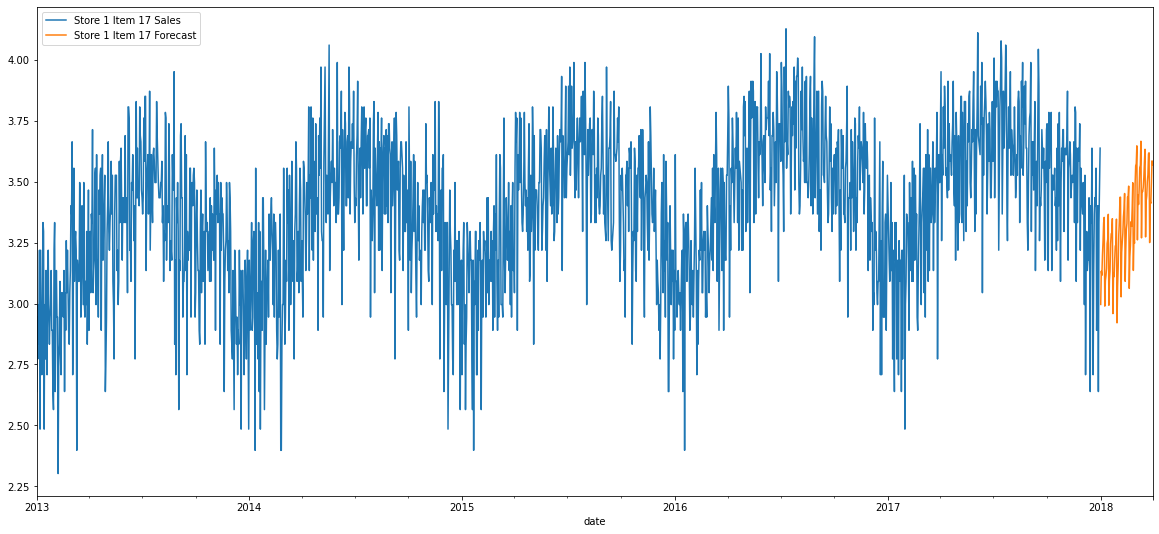

In [32]:
train[(train.store == 1) & (train.item == 17)].set_index("date").sales.plot(figsize = (20,9),legend=True, label = "Store 1 Item 17 Sales")
forecast[(forecast.store == 1) & (forecast.item == 17)].set_index("date").sales.plot(legend=True, label = "Store 1 Item 17 Forecast");

## 5. TIME SERIES PART

* Bu bölümde öncelikle train veri seti haftalığa indirgenecektir.
* Daha sonra haftalığa indirgenmiş veri seti kullanılarak sırasıyla :
* LightGBM Model 
* Single Exponential Smoothing
* Double Exponential Smoothing
* Triple Exponential Smoothing
* ARIMA
* SARIMA ile 2017 yılına ait satış talep tahmin modelleri oluşturulacaktır.
* Gerçek değerler ile tahmin edilen değerler karşılaştırılacaktır.


### Load Dataset and EDA

In [33]:
data = pd.read_csv('../input/demand-forecasting-kernels-only/train.csv', parse_dates=['date'])
data.head()
data.shape

# veri setini haftalığa indirgeme
data.set_index("date",inplace=True)
df= data.resample("W").mean()
df.reset_index(inplace=True)
df.head()
df.shape

df.index.freq = "W"
df.head()

,date,store,item,sales
0,2013-01-06,5.5,25.5,30.355667
1,2013-01-13,5.5,25.5,29.686286
2,2013-01-20,5.5,25.5,29.414286
3,2013-01-27,5.5,25.5,29.513714
4,2013-02-03,5.5,25.5,31.150571


In [34]:
df.shape

(261, 4)

### Feature Engineering

In [35]:
# hangi ayda satış yapılmış
df['month'] = df.date.dt.month
# ayın hangi gününde satış yapılmış
df['day_of_month'] = df.date.dt.day
# yılın hangi gününde satış yapılmış
df['day_of_year'] = df.date.dt.dayofyear
# yılın hangi haftasında satış yapılmış
df['week_of_year'] = df.date.dt.weekofyear
# haftanın hangi gününde satış yapılmış
df['day_of_week'] = df.date.dt.dayofweek
# hangi yılda satış yapılmış
df['year'] = df.date.dt.year
# haftasonu mu değil mi
df["is_wknd"] = df.date.dt.weekday // 4
# ayın başlangıcı mı
df['is_month_start'] = df.date.dt.is_month_start.astype(int)
# ayın bitişi mi
df['is_month_end'] = df.date.dt.is_month_end.astype(int)

# Lag/Shifted Features (Gecikmeler)
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [31, 61, 91, 98, 105, 112])


# Rolling Mean Features (Hareketli Ortalamalar)
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [31, 61, 91, 98, 105, 112])


# Exponentially Weighted Mean Features (Üssel Ağırlıklı Ortalama Featurs
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


alphas = [0.99, 0.95, 0.9, 0.8, 0.7, 0.5]
lags = [10, 20, 30, 40, 50]

df = ewm_features(df, alphas, lags)

df.tail()


,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_31,sales_lag_61,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_roll_mean_31,sales_roll_mean_61,sales_roll_mean_91,sales_roll_mean_98,sales_roll_mean_105,sales_roll_mean_112,sales_ewm_alpha_099_lag_10,sales_ewm_alpha_099_lag_20,sales_ewm_alpha_099_lag_30,sales_ewm_alpha_099_lag_40,sales_ewm_alpha_099_lag_50,sales_ewm_alpha_095_lag_10,sales_ewm_alpha_095_lag_20,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_095_lag_40,sales_ewm_alpha_095_lag_50,sales_ewm_alpha_09_lag_10,sales_ewm_alpha_09_lag_20,sales_ewm_alpha_09_lag_30,sales_ewm_alpha_09_lag_40,sales_ewm_alpha_09_lag_50,sales_ewm_alpha_08_lag_10,sales_ewm_alpha_08_lag_20,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_08_lag_40,sales_ewm_alpha_08_lag_50,sales_ewm_alpha_07_lag_10,sales_ewm_alpha_07_lag_20,sales_ewm_alpha_07_lag_30,sales_ewm_alpha_07_lag_40,sales_ewm_alpha_07_lag_50,sales_ewm_alpha_05_lag_10,sales_ewm_alpha_05_lag_20,sales_ewm_alpha_05_lag_30,sales_ewm_alpha_05_lag_40,sales_ewm_alpha_05_lag_50
256,2017-12-03,5.5,25.5,53.510286,12,3,337,48,6,2017,1,0,0,62.927376,57.232877,51.163516,35.335638,54.059349,51.688794,64.914129,58.861839,56.220778,55.861659,57.927554,57.931257,61.944343,75.326579,66.655854,44.464902,42.682299,61.949367,75.308760,66.468077,44.460477,42.696424,61.957303,75.273841,66.233661,44.454102,42.750531,61.987351,75.156915,65.763164,44.431749,43.010549,62.055540,74.967582,65.279091,44.379961,43.525509,62.454476,74.293534,64.107567,44.083539,45.549427
257,2017-12-10,5.5,25.5,44.114286,12,10,344,49,6,2017,1,0,0,66.307926,54.604405,50.627738,40.673234,41.530970,48.866012,66.784602,60.809967,58.737397,58.396148,56.740918,56.281709,61.176895,75.422743,66.631673,50.817829,42.680306,61.208154,75.417967,66.623261,50.560924,42.681093,61.247959,75.408727,66.591652,50.239210,42.687310,61.332784,75.370354,66.457776,49.591950,42.746338,61.435062,75.286875,66.225727,48.931388,42.933853,61.811809,74.858624,65.369498,47.482770,44.114856
258,2017-12-17,5.5,25.5,44.370286,12,17,351,50,6,2017,1,0,0,64.728484,57.594399,51.805312,37.649376,41.417325,50.796132,68.650062,56.161344,57.815662,55.552370,58.848632,58.529470,57.585703,75.263325,66.745140,53.133184,41.904974,57.732365,75.269527,66.740134,53.026789,41.936340,57.919282,75.276416,66.730822,52.864835,41.976160,58.306100,75.283442,66.688584,52.443647,42.066982,58.715119,75.269262,66.590118,51.889017,42.208156,59.680619,75.060169,66.057892,50.319670,43.005999
259,2017-12-24,5.5,25.5,44.423429,12,24,358,51,6,2017,1,0,0,66.014287,56.053127,51.959641,40.276276,41.273584,49.183436,64.863853,60.370295,59.083997,60.894629,56.998711,59.413495,57.708474,67.553308,66.586743,53.126072,40.050730,57.710847,67.865133,66.592892,53.121039,40.127217,57.730671,68.255527,66.599711,53.099884,40.226416,57.828991,69.037031,66.605831,52.989529,40.438996,58.011336,69.813579,66.586635,52.754905,40.684847,58.695167,71.267799,66.321517,51.722835,41.519000
260,2017-12-31,5.5,25.5,44.417429,12,31,365,52,6,2017,1,0,1,67.752172,54.953641,54.379937,43.985399,40.116213,54.963367,64.445192,59.799960,55.330062,57.198306,55.012593,56.222958,57.943342,66.656487,68.985485,53.177198,39.972504,57.933971,66.708314,68.888873,53.174881,39.979489,57.924210,66.808238,68.768714,53.169931,39.997184,57.922370,67.125349,68.528938,53.140077,40.065171,57.965401,67.597274,68.282791,53.050871,40.185654,58.320440,68.957614,67.665616,52.450275,40.745357


### LightGBM Model

In [36]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['day_of_week', 'month'])

# Converting sales to log(1+sales)
df['sales'] = np.log1p(df["sales"].values)

# train-test seti
train = df.loc[(df["date"] < "2017-01-01"), :]
test = df.loc[(df["date"] >= "2017-01-01"), :]

# bağımlı ve bağımsız değişkenler
cols = [col for col in train.columns if col not in ['date', "sales", "year"]]
X_train = train[cols]
Y_train = train['sales']
X_test = test[cols]
Y_test = test["sales"]


In [37]:
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000, 
              'early_stopping_rounds': 200, 
              'nthread': -1}

lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_test, label=Y_test, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape, 
                  verbose_eval=100)

y_pred_test = model.predict(X_test, num_iteration=model.best_iteration)

# test hatasının yüzdesi
smape(np.expm1(y_pred_test), np.expm1(Y_test))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

2.827915714992037

### Feature Importance

                       feature  split       gain
49   sales_ewm_alpha_05_lag_50    407  46.724131
44   sales_ewm_alpha_07_lag_50    380  15.915420
3                  day_of_year   1612  10.962109
4                 week_of_year    929   5.438331
12               sales_lag_105    322   3.329201
17          sales_roll_mean_98    260   2.575401
15          sales_roll_mean_61    191   2.061211
34   sales_ewm_alpha_09_lag_50     67   1.387624
23  sales_ewm_alpha_099_lag_40    311   1.235901
20  sales_ewm_alpha_099_lag_10    284   1.058083
39   sales_ewm_alpha_08_lag_50    141   0.998022
21  sales_ewm_alpha_099_lag_20    361   0.926349
45   sales_ewm_alpha_05_lag_10    229   0.806595
29  sales_ewm_alpha_095_lag_50    117   0.759065
41   sales_ewm_alpha_07_lag_20    277   0.595840
22  sales_ewm_alpha_099_lag_30    318   0.457361
2                 day_of_month    937   0.443665
8                 sales_lag_31    440   0.345001
9                 sales_lag_61    241   0.330575
37   sales_ewm_alpha

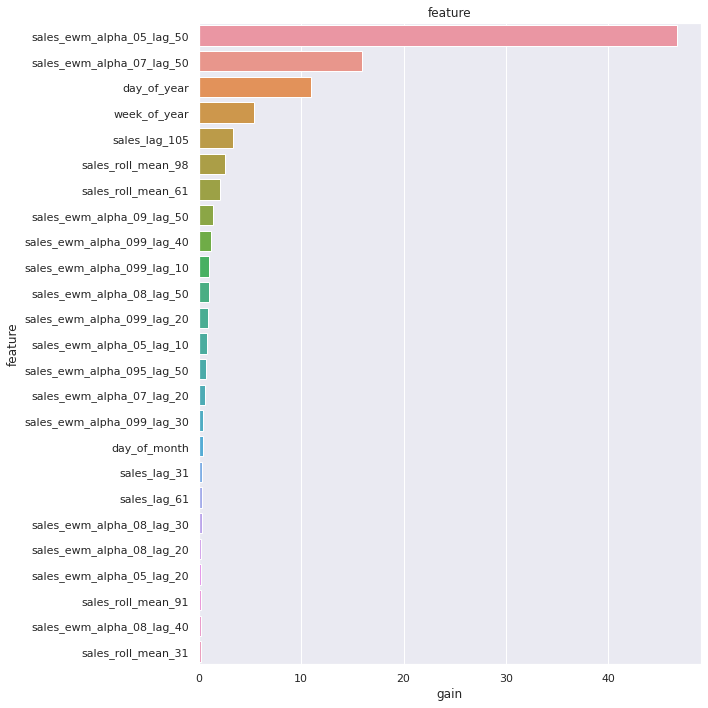

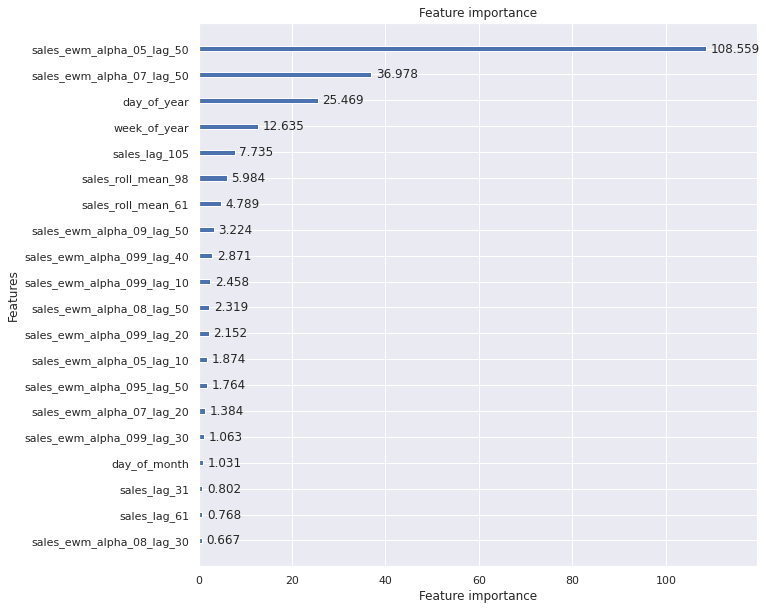

In [38]:
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))


plot_lgb_importances(model, num=30)
plot_lgb_importances(model, num=30, plot=True)

lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type="gain")
plt.show()


In [39]:
# Final Model

lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = model.predict(X_test, num_iteration=model.best_iteration)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

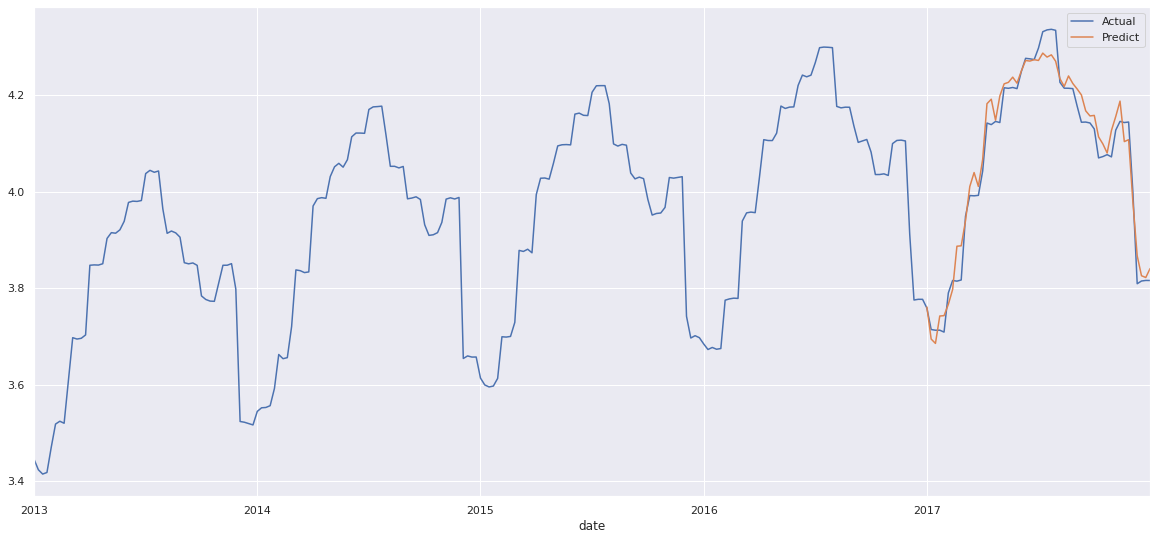

In [40]:
# 1 yıllık gerçek ve tahmin edilen değerler
forecast = pd.DataFrame({"date":test["date"],
                        "store":test["store"],
                        "item":test["item"],
                        "sales":test_preds
                        })

df.set_index("date").sales.plot(figsize = (20,9),legend=True, label = "Actual")
forecast.set_index("date").sales.plot(legend=True, label = "Predict")
plt.show()

### Time Series Analysis

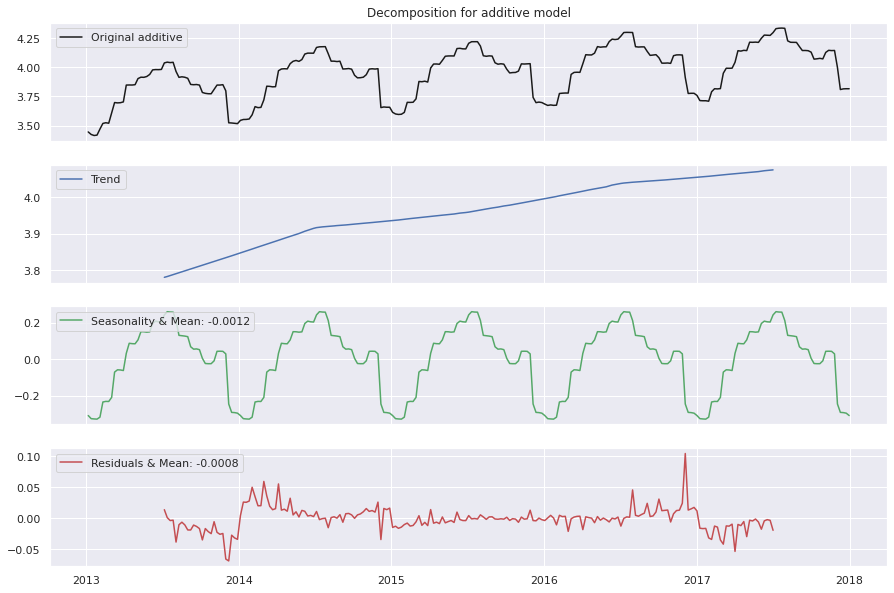

In [41]:
df.index.freq = "W"
dff = pd.DataFrame({"date":df["date"], "sales":df["sales"]})
dff.index = dff["date"]
dff.drop("date",axis=1, inplace=True)
dff.head()

# Durağanlık Testi (Dickey-Fuller Testi)
def is_stationary(y):

    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        print(F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        print(F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")

# Zaman Serisi Bileşenleri ve Durağanlık Testi
def ts_decompose(y, model="additive", stationary=False):
    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

    if stationary:
        is_stationary(y)

ts_decompose(dff, model="additive")

### Single Exponential Smoothing (SES)

alpha: 0.01 mae: 0.1965
alpha: 0.11 mae: 0.1834
alpha: 0.21 mae: 0.2224
alpha: 0.31 mae: 0.2486
alpha: 0.41 mae: 0.2666
alpha: 0.51 mae: 0.2815
alpha: 0.61 mae: 0.2926
alpha: 0.71 mae: 0.2989
alpha: 0.81 mae: 0.3017
alpha: 0.91 mae: 0.3025
best_alpha: 0.11 best_mae: 0.1834


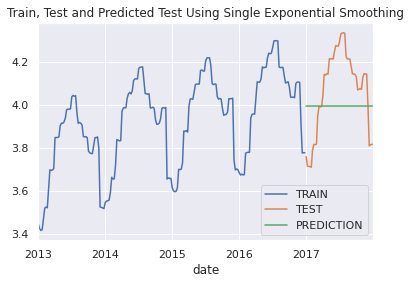

In [42]:
train_dff = dff.loc[(dff.index < "2017-01-01"), :]
test_dff = dff.loc[(dff.index >= "2017-01-01"), :]

dff.index.freq = "W"

def ses_optimizer(train, alphas, step=48):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test_dff, y_pred)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae

alphas = np.arange(0.01, 1, 0.10)
best_alpha, best_mae = ses_optimizer(train_dff, alphas, step=53)

ses_model = SimpleExpSmoothing(train_dff).fit(smoothing_level=best_alpha)
y_pred = ses_model.forecast(53)

def plot_prediction(y_pred, label):
    train_dff["sales"].plot(legend=True, label="TRAIN")
    test_dff["sales"].plot(legend=True, label="TEST")
    y_pred.plot(legend=True, label="PREDICTION")
    plt.title("Train, Test and Predicted Test Using "+label)
    plt.show()

plot_prediction(y_pred, "Single Exponential Smoothing")


### Double Exponential Smoothing

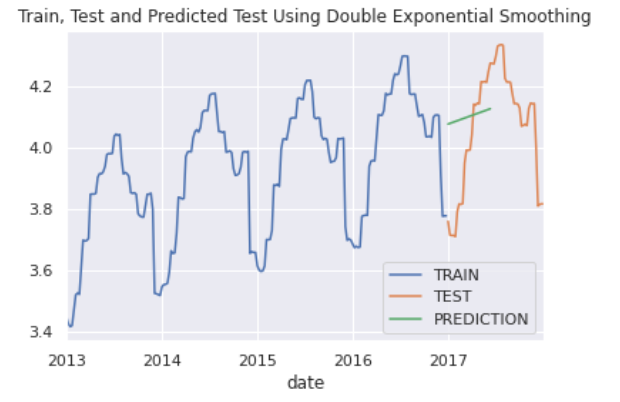

### Triple Exponential Smoothing 

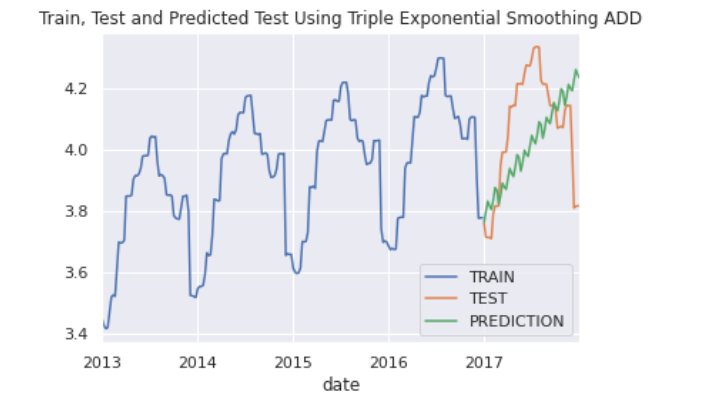

### ARIMA

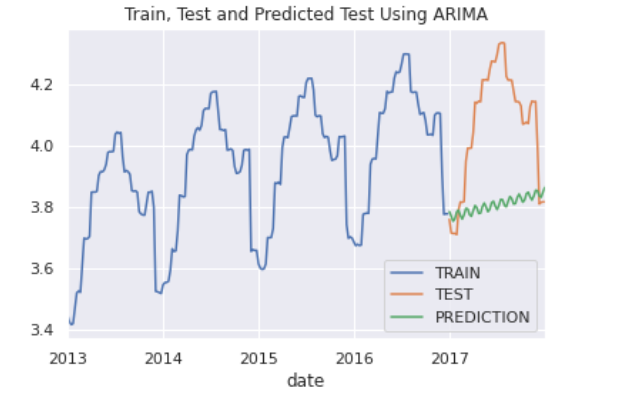

### SARIMA

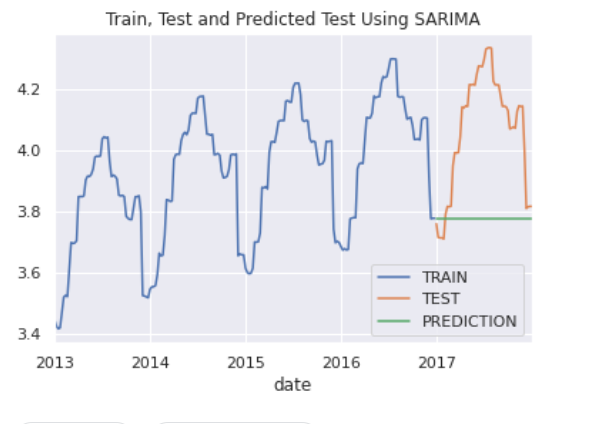